# Model

In [41]:
# | default_exp models.hospitalization

In [42]:
# | export
from pyprojroot.here import here
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
from isssm.typing import PGSSM
from tensorflow_probability.substrates.jax.distributions import Poisson
from jax import config

config.update("jax_enable_x64", True)

In [43]:
# | export
from ssm4epi.models.util import from_consecutive_logits, to_consecutive_logits
import jax.scipy as jsp


def hospitalization_model(theta, aux) -> PGSSM:
    # log_s2_p, log_s2_q, *log_q = theta
    log_s2_p, log_s2_q, log_s2_W, log_s2_0, log_p0 = theta
    # log_q = jnp.array(log_q)
    s2_p = jnp.exp(log_s2_p)
    s2_q = jnp.exp(log_s2_q)
    s2_W = jnp.exp(log_s2_W)
    s2_0 = jnp.exp(log_s2_0)

    np1, n_delay, n_weekday, I = aux
    n = np1 - 1

    r = 1 + (n_delay - 1) + n_weekday
    m = (1 + 1) + (n_delay - 1) + 6 * n_weekday
    p = n_delay

    u0 = jnp.eye(m)[0] * log_p0
    # A_p = jnp.eye(1)
    A_p = jnp.array([[1.0, 1.0], [0.0, 1.0]])
    A_q = jnp.eye(n_delay - 1)
    A_W = jnp.array(
        [
            [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        ]
    )
    A = jsp.linalg.block_diag(A_p, A_q, *[A_W for i in range(n_weekday)])
    D = jnp.hstack(
        [
            jnp.eye(m)[:, 1 : n_delay + 1],
            jnp.eye(m)[:, n_delay + 1 : n_delay + 2],
            jnp.eye(m)[:, n_delay + 7 : n_delay + 8],
        ]
    )
    Sigma0 = s2_0 * jnp.eye(m)
    Sigma = jnp.diag(
        jnp.array([s2_p, *jnp.repeat(s2_q, n_delay - 1), *jnp.repeat(s2_W, n_weekday)])
    )

    # B = jnp.hstack((jnp.ones((p, 1)), jnp.eye(m - 1)))
    def B_W(i):
        return jnp.zeros((p, 6)).at[i + 1, 0].set(1.0)

    B_p = jnp.hstack((jnp.eye(p)[:, 0:1], jnp.zeros((p, 1))))
    B_logits = jnp.eye(p)[:, 1:]
    B_Ws = [B_W(i) for i in range(n_weekday)]
    B = jnp.hstack([B_p, B_logits, *B_Ws])

    u = jnp.zeros((np1, m)).at[0].set(u0)
    A = jnp.broadcast_to(A, (n, m, m))
    D = jnp.broadcast_to(D, (n, m, r))
    Sigma = jnp.broadcast_to(Sigma, (n, r, r))
    v = jnp.zeros((np1, p))
    B = jnp.broadcast_to(B, (np1, p, m))

    def hospitalization_dist(signal, xi):
        log_I7 = xi[..., :1, 0]

        log_p, logit_qs = jnp.split(signal, [1], axis=-1)
        log_delay_probs = jnp.log(from_consecutive_logits(logit_qs))
        log_lambda = log_I7 + log_p + log_delay_probs

        return Poisson(log_rate=log_lambda)

    dist = hospitalization_dist
    xi = jnp.broadcast_to(jnp.log(I)[:, None, None], (np1, p, 1))
    return PGSSM(u, A, D, Sigma0, Sigma, v, B, dist, xi)

In [44]:
# | export

import isssm.laplace_approximation
from jax.lax import cond


def _initial_guess(xi_t, y_t, dist, link=isssm.laplace_approximation.default_link):
    log_I7 = xi_t[0, 1]
    log_p_est = jnp.log(y_t.sum()) - log_I7
    # slightly biased to avoid log(0)
    delay_probs_est = (y_t + 1.0) / (y_t + 1.0).sum()
    logit_delay_est = to_consecutive_logits(delay_probs_est)
    nan_guess = jnp.array(
        [jnp.log(2 * jnp.nansum(y_t)) - log_I7, *jnp.full((y_t.size - 1,), 0.0)]
    )

    non_nan_guess = jnp.array([log_p_est, *logit_delay_est])
    any_missing = jnp.any(xi_t[..., 0] == 1)
    return cond(any_missing, lambda *_: nan_guess, lambda *_: non_nan_guess)


isssm.laplace_approximation._initial_guess = _initial_guess
from ssm4epi.patch import full_deps

In [45]:
# | export

hospitalization_data = pd.read_csv(here() / "data/processed/seven_day_H_I_by_age.csv")

unique_a = hospitalization_data["a"].unique()
dates = hospitalization_data["s"].unique()
h_by_age = [
    jnp.asarray(
        hospitalization_data[hospitalization_data["a"] == a]
        .pivot(index="s", columns="k", values="h")
        .to_numpy()
    )
    for a in unique_a
]
I_by_age = [
    jnp.asarray(
        hospitalization_data[hospitalization_data["a"] == a]
        .pivot(index="s", columns="k", values="I")
        .to_numpy()
    )[:, 0]
    for a in unique_a
]

- NowcastHub period: Monday 22 November 2021 to Friday 29 April 2022
- date of final evaluation: 8 August 2022

In [46]:
dates[0], dates[-1]

('2021-04-05', '2023-10-04')

In [47]:
a_index = 0
h = h_by_age[a_index]
I = I_by_age[a_index]
unique_a[a_index]

'00-04'

In [48]:
[jnp.max(h_by_age[i].sum(axis=-1) / I_by_age[i]) for i in range(len(unique_a))]

[Array(0.88235294, dtype=float64),
 Array(0.42857143, dtype=float64),
 Array(0.20802005, dtype=float64),
 Array(0.31587057, dtype=float64),
 Array(0.74633431, dtype=float64),
 Array(1.09724473, dtype=float64),
 Array(0.63493344, dtype=float64)]

In [49]:
np1 = 158
i_start = 231
i_end = i_start + np1

n_delay = 4
y = h[i_start : i_start + np1, :n_delay]

p0_hat = y[:7].sum() / I[i_start : i_start + 7].sum()
n_weekday = 2
aux = (np1, n_delay, n_weekday, I[i_start : i_start + np1])
theta_manual = jnp.log(
    jnp.array(
        [1**2, 1**2, 0.1**2, 0.1**2, p0_hat]  # s2_p  # s2_q  # s2_W  # p0  # s2_0
    )
)

model_manual = hospitalization_model(theta_manual, aux)

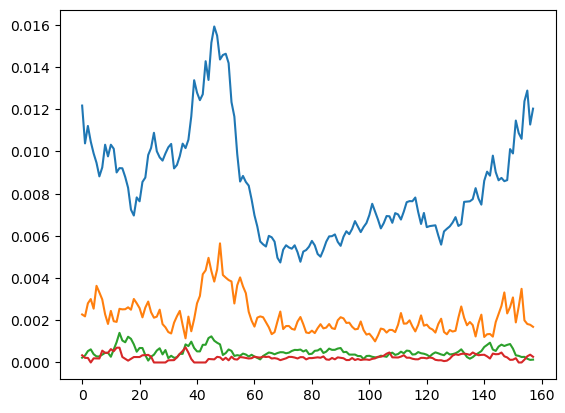

In [50]:
plt.plot(y / I[i_start : i_start + np1][:, None])

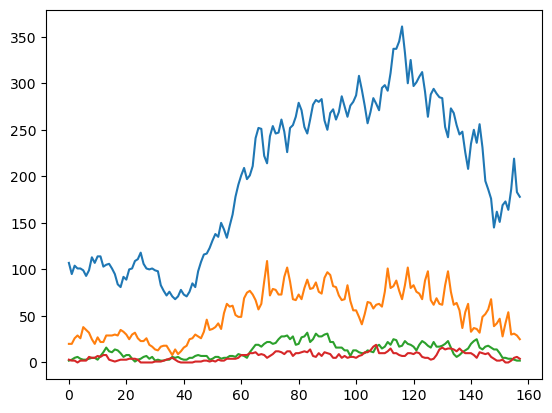

In [51]:
plt.plot(y)
plt.show()

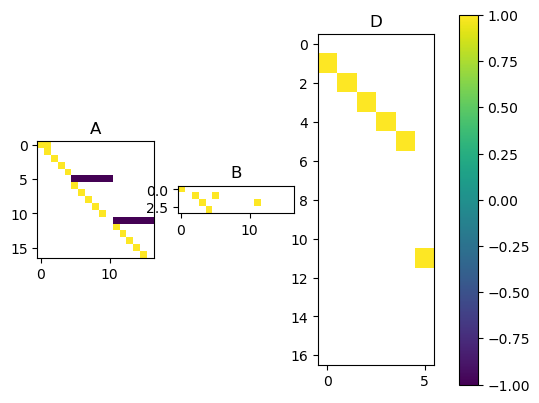

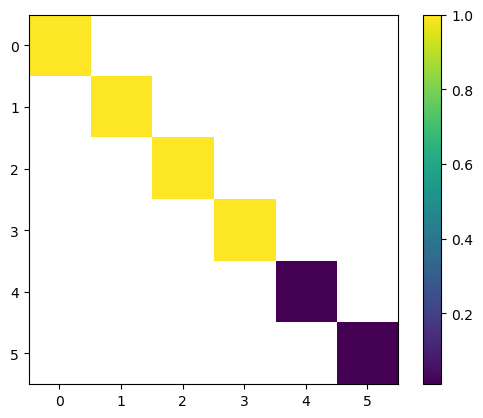

In [52]:
from ssm4epi.models.util import visualize_pgssm

visualize_pgssm(model_manual)

In [53]:
from isssm.estimation import initial_theta

theta0_result = initial_theta(y, hospitalization_model, theta_manual, aux, 100)
theta0 = theta0_result.x
theta0_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.1679917947612553
        x: [-8.859e+00 -4.440e+00 -1.806e+01 -1.757e+00 -4.245e+00]
      nit: 47
      jac: [ 6.375e-06 -1.721e-06  4.811e-07  7.139e-06 -7.210e-06]
 hess_inv: [[ 5.299e+01 -8.239e-01 ...  8.839e+00  5.897e+00]
            [-8.239e-01  2.388e+01 ...  1.343e+00 -3.406e-02]
            ...
            [ 8.839e+00  1.343e+00 ...  8.132e+01  4.571e+00]
            [ 5.897e+00 -3.406e-02 ...  4.571e+00  1.008e+02]]
     nfev: 550
     njev: 50

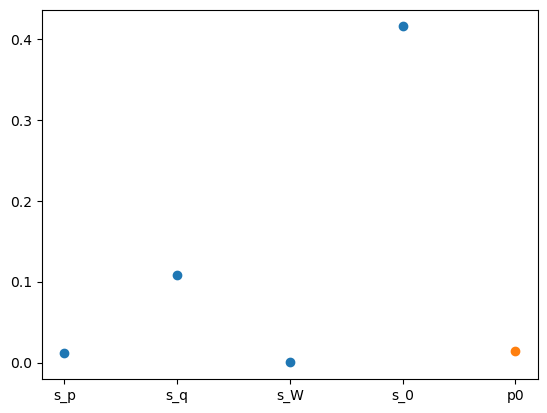

In [54]:
model0 = hospitalization_model(theta0, aux)
sds = jnp.exp(theta0[:4] / 2)
p0 = jnp.exp(theta0[4])
plt.scatter(jnp.arange(4), sds)
plt.scatter(4, p0)
plt.xticks(jnp.arange(5), ["s_p", "s_q", "s_W", "s_0", "p0"])
plt.show()

In [55]:
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct
import jax.random as jrn

proposal_la, info_la = LA(y, model0, 100)
key = jrn.PRNGKey(423423423)
key, subkey = jrn.split(key)
proposal_meis, info_meis = MEIS(
    y, model0, proposal_la.z, proposal_la.Omega, 100, 10000, subkey
)
key, subkey = jrn.split(key)
samples, log_weights = pgssm_importance_sampling(
    y, model0, proposal_meis.z, proposal_meis.Omega, 1000, subkey
)
ess_pct(log_weights)

Array(67.45223992, dtype=float64)

In [56]:
# | export
from isssm.importance_sampling import mc_integration
from isssm.kalman import state_mode
from jax import vmap
from isssm.importance_sampling import ess_pct


def visualize_model_fit(samples, log_weights, model, i_start, np1, y, a_index):
    post = mc_integration(samples, log_weights)
    post_state = mc_integration(
        vmap(state_mode, (None, 0))(model, samples), log_weights
    )

    _, n_delay = y.shape

    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    fig.suptitle(f"Age group {unique_a[a_index]} - ESS {ess_pct(log_weights):.2f}%")
    fig.tight_layout()
    axs = axs.flatten()

    axs[0].plot(
        jnp.exp(post[:, 0]) * I_by_age[a_index][i_start : i_start + np1],
        label="predicted",
    )
    axs[0].plot(y.sum(axis=-1), label="truth")
    axs[0].legend()
    axs[0].set_title(f"Total hospitalizations after {n_delay} weeks")

    axs[1].plot(jnp.exp(post_state[:, 0]))
    axs[1].set_title("probability of hospitalization")

    axs[2].plot(from_consecutive_logits(post[:, 1:]), linestyle="--")
    axs[2].plot(from_consecutive_logits(post_state[:, 2 : (2 + n_delay - 1)]))
    axs[2].set_title("delay probabilities")

    axs[3].plot(post_state[:, 2 : (2 + n_delay - 1)])
    axs[3].set_title("delay logits")

    axs[4].plot(post_state[:, (2 + n_delay - 1)])
    axs[4].plot(post_state[:, (2 + n_delay - 1) + 6])
    axs[4].set_title("weekday effects")

    axs[5].plot(post_state[:, 1])
    axs[5].set_title("hosp. prob speed")

    plt.show()

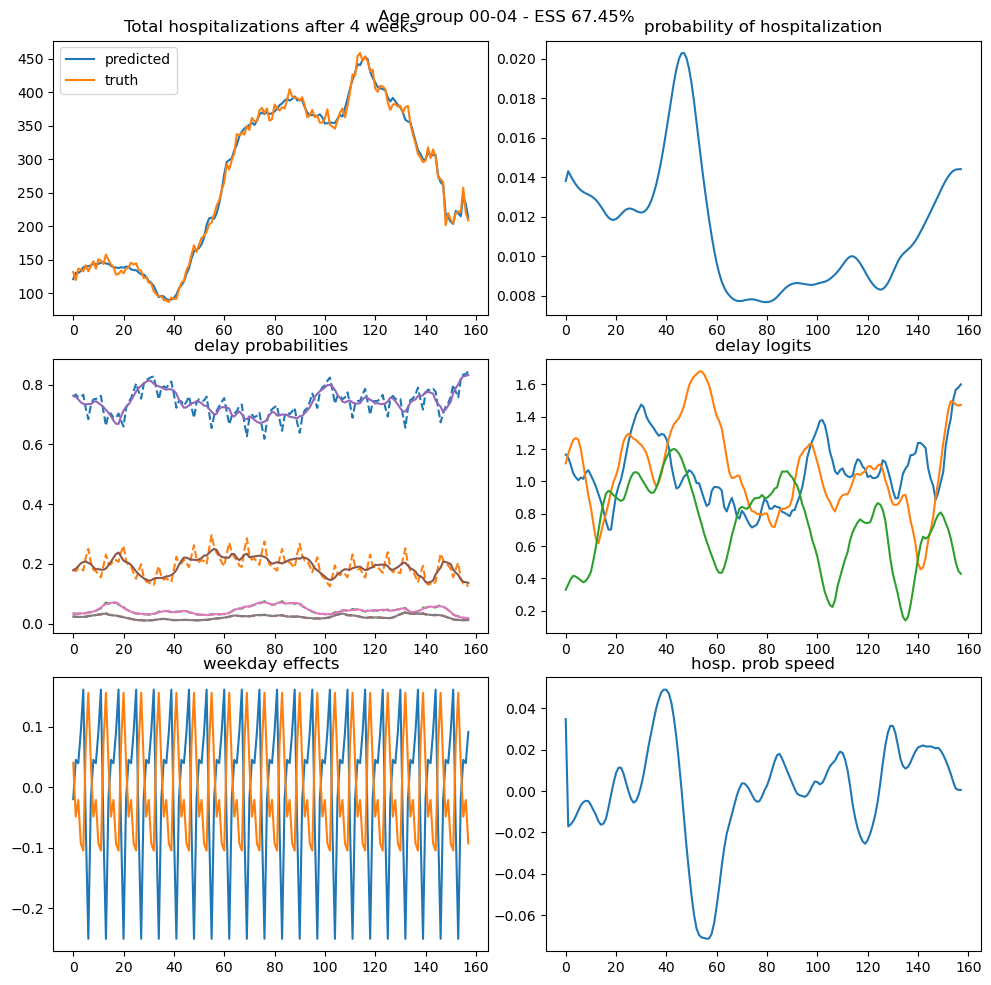

In [57]:
visualize_model_fit(samples, log_weights, model0, i_start, np1, y, a_index)

## Missigness

Deviate from standard setup: now missing indices of $B$ differ from those of $Y$.

In [58]:
# | export
from jaxtyping import Array, Float


def account_for_nans(
    model: PGSSM, y, missing_y_indices, missing_s_indices
) -> tuple[PGSSM, Float]:
    # only works for Poisson!
    # missing_indices = jnp.isnan(y)

    y_missing = jnp.nan_to_num(y, nan=0.0)

    v = model.v.at[missing_s_indices].set(0.0)
    B = model.B.at[missing_s_indices].set(0.0)

    xi_missing = jnp.ones_like(y).at[missing_y_indices].set(0.0)[..., None]
    xi = jnp.concatenate([xi_missing, model.xi], -1)

    def missing_dist(s, xi):
        xi_missing, old_xi = xi[..., 0], xi[..., 1:]
        old_dist = model.dist(s, old_xi)
        # if xi == 0. the log rate becomes -inf, so dist is dirac_0
        return Poisson(log_rate=old_dist.log_rate + jnp.log(xi_missing))

    model_missing = PGSSM(
        u=model.u,
        A=model.A,
        D=model.D,
        Sigma0=model.Sigma0,
        Sigma=model.Sigma,
        v=v,
        B=B,
        dist=missing_dist,
        xi=xi,
    )

    return model_missing, y_missing

test: make everything in the last week of observations missing, except initial observation

In [65]:
# | export
from jax.lax import fori_loop


def make_y_nan(y: Float):
    _, n_delay = y.shape
    y_nan = y.astype(jnp.float64)
    for i in range(n_delay):
        y_nan = y_nan.at[(-7 * (i + 1) + 1), (i + 1) :].set(jnp.nan)
    return y_nan

In [78]:
y_nan = make_y_nan(y)
# need fewer data for missingness
np1_miss = 100
y_nan = y_nan[-np1_miss:]
missing_y_indices = jnp.isnan(y_nan)
missing_s_indicies = jnp.concatenate(
    (jnp.full((np1_miss, 1), False, dtype=bool), missing_y_indices[:, :-1]), axis=-1
)
aux_miss = (np1_miss, n_delay, n_weekday, I[i_start + (np1 - np1_miss) : i_start + np1])

theta_manual_missing = theta0
_, y_miss = account_for_nans(
    hospitalization_model(theta0, aux_miss),
    y_nan,
    missing_y_indices,
    missing_s_indicies,
)
_model_miss = lambda theta, aux: account_for_nans(
    hospitalization_model(theta, aux), y_nan, missing_y_indices, missing_s_indicies
)[0]

theta0_missing_result = initial_theta(
    y_miss, _model_miss, theta_manual_missing, aux_miss, 10
)
theta0_missing = theta0_missing_result.x
theta0_missing_result

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3.7406543984139886
        x: [-8.858e+00 -4.438e+00 -1.806e+01 -1.764e+00 -4.243e+00]
      nit: 2
      jac: [-3.467e+01 -4.477e-02 -1.622e+02 -1.244e+03  4.386e-03]
 hess_inv: [[ 9.973e-01 -1.315e-02 ...  1.199e-01 -6.872e-03]
            [-1.315e-02  4.591e-01 ...  2.300e-01  4.709e-01]
            ...
            [ 1.199e-01  2.300e-01 ...  1.428e-01  2.451e-01]
            [-6.872e-03  4.709e-01 ...  2.451e-01  4.890e-01]]
     nfev: 650
     njev: 58

In [89]:
model_miss0 = _model_miss(theta0_missing, aux_miss)
proposal_la, info_la = LA(y_miss, model_miss0, 100)
# key, subkey = jrn.split(key)
# proposal_meis, info_meis = MEIS(
#    y_miss,
#    model_miss0,
#    proposal_la.z,
#    proposal_la.Omega,
#    100,
#    10000,
#    subkey,
# )
key, subkey = jrn.split(key)
samples, log_weights = pgssm_importance_sampling(
    y_miss,
    model_miss0,
    proposal_la.z,
    proposal_la.Omega,
    10000,
    subkey,
)

ess_pct(log_weights)

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Array(0.0025, dtype=float64)

In [90]:
# | hide
import nbdev

nbdev.nbdev_export()

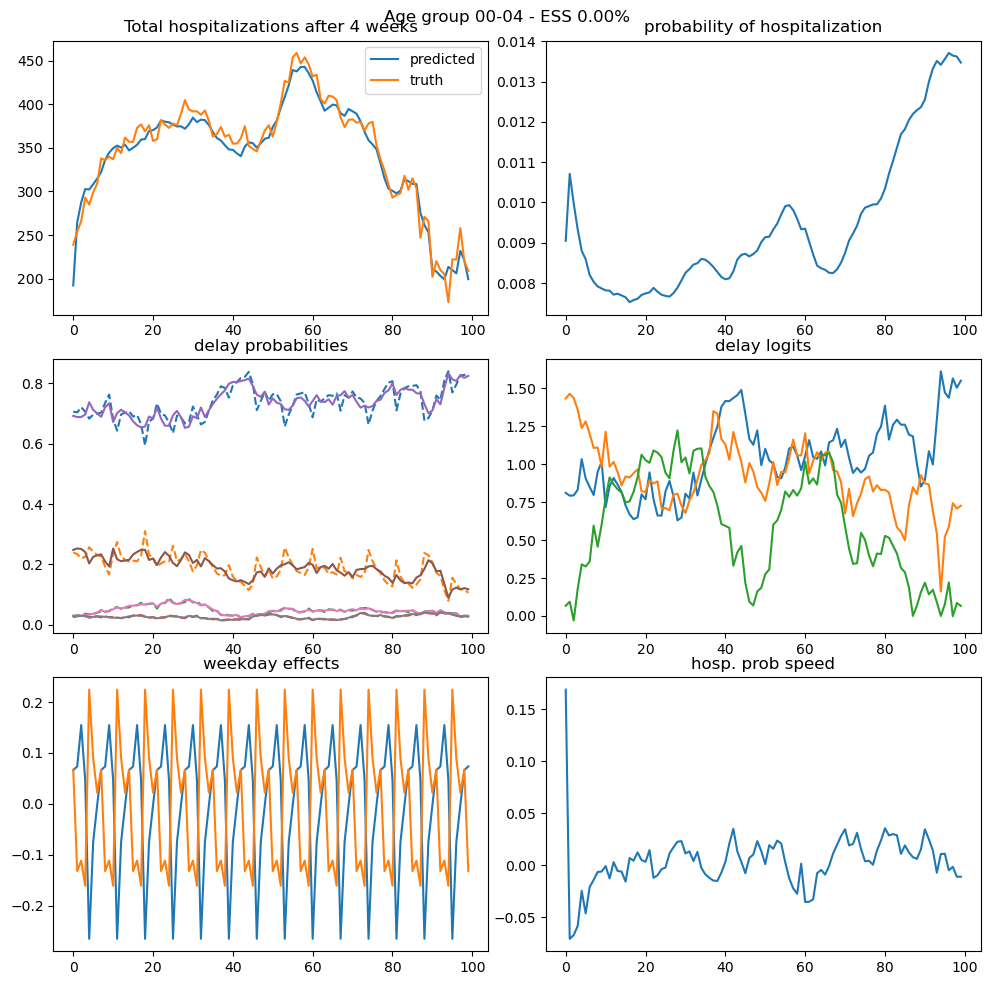

In [91]:
visualize_model_fit(
    samples,
    log_weights,
    model_miss0,
    i_start + (np1 - np1_miss),
    np1_miss,
    y_miss,
    a_index,
)

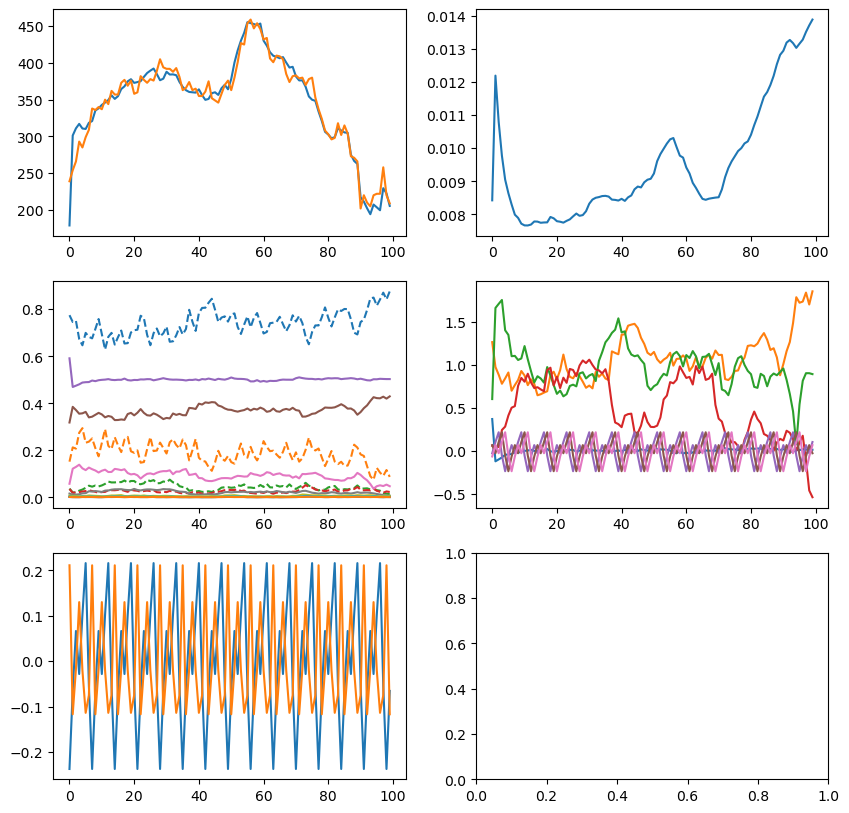

In [86]:
post = mc_integration(samples, log_weights)
post_state = mc_integration(
    vmap(state_mode, (None, 0))(model_miss0, samples), log_weights
)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()
axs[0].plot(jnp.exp(post[:, 0]) * I[i_start + (np1 - np1_miss) : i_start + np1])
axs[0].plot(y[-(np1_miss):].sum(axis=-1))
axs[1].plot(jnp.exp(post[:, 0]))

axs[2].plot(from_consecutive_logits(post[:, 1:]), linestyle="--")
axs[2].plot(from_consecutive_logits(post_state[:, 1:8]))
axs[3].plot(post_state[:, 1:8])
axs[4].plot(post_state[:, 8])
axs[4].plot(post_state[:, 8 + 6])

plt.show()

In [70]:
from isssm.importance_sampling import prediction


def f_nowcast(x, s, y):
    return y.sum(axis=-1)


key, subkey = jrn.split(key)
preds = prediction(
    f_nowcast,
    y_miss,
    proposal_meis,
    _model_miss(theta0_missing, aux),
    10000,
    subkey,
    jnp.array([0.025, 0.5, 0.975]),
    hospitalization_model(theta0_missing, aux),
)

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


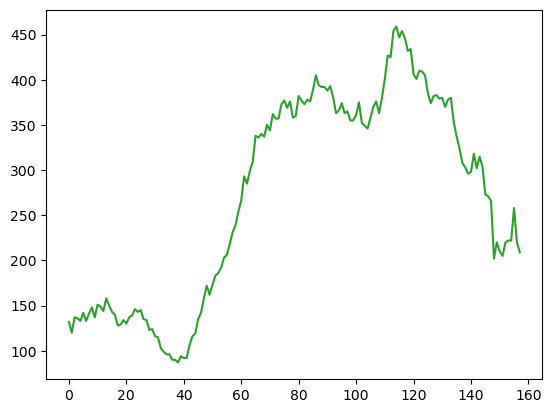

In [71]:
plt.plot(preds[0])
plt.plot(preds[2][1])
plt.plot(jnp.clip(preds[2][0], 0.0), linestyle="--", color="grey")
plt.plot(preds[2][2], linestyle="--", color="grey")
plt.plot(y.sum(axis=-1))
plt.show()

In [72]:
# | hide
import nbdev

nbdev.nbdev_export()